/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
To: /content/kernel_pde_utils.py
100% 4.81k/4.81k [00:00<00:00, 16.6MB/s]


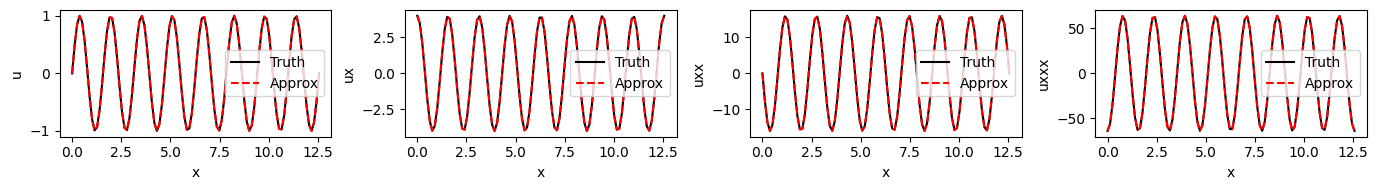

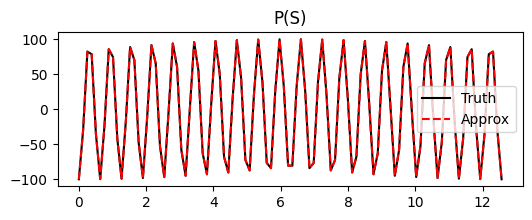

In [1]:
import numpy as np
import matplotlib.pyplot as plt

! gdown --id 1XITm_SGl1Zg7KbOCVmBmOGoFQpbkIxHZ
from kernel_pde_utils import *
test_step1()
test_step2()

# Compute benchmarking error

In [2]:
def compute_error(true, est):
    """Relative error."""
    return np.linalg.norm(true - est) / np.linalg.norm(true)

### Modified from utils file.
def test_step1_error(noise_mag, _lambda, a=4):
    """
    Benchmarking for kernel smoothing and differentiation step.
    Benchmarks against the function u(x) = sin(ax).
    """
    # Evaluate true function values.
    x = np.linspace(0, 4 * np.pi, 100)
    u_true = np.sin(a * x)
    ux_true = a * np.cos(a * x)
    uxx_true = -(a ** 2) * np.sin(a * x)

    # Add noise to data?
    rng = np.random.default_rng(seed=144) # seed for reproducibility
    u_noisy = u_true + (noise_mag * rng.standard_normal(len(u_true)))

    # Get smooth u.
    u_func = kernel_smoothing(x[:, None], u_noisy, kernel_params={"gamma":1}, _lambda=_lambda)
    u_est = u_func(x[:, None])

    # Get ux.
    ux_func = kernel_diff(x[:, None], u_est, d=1, kernel_params={"gamma":1}, _lambda=_lambda)
    ux_est = np.array([ux_func(np.array(xi)) for xi in x])

    # Get uxx.
    uxx_func = kernel_diff(x[:, None], u_est, d=2, kernel_params={"gamma":1}, _lambda=_lambda)
    uxx_est = np.array([uxx_func(np.array(xi)) for xi in x])

    # Plot the computed derivatives.
    plt.figure(figsize=(14, 2))
    for i, (truth, est, label) in enumerate(
        zip([u_true, ux_true, uxx_true],
            [u_est, ux_est, uxx_est],
            ["u", "ux", "uxx"])
    ):
        plt.subplot(1, 4, i + 1)
        plt.plot(x, truth, c="k", label="Truth")
        plt.plot(x, est, "--", c="r", label="Approx")
        plt.xlabel("x")
        plt.ylabel(label)
        plt.legend()
        print(f"{label} error: {compute_error(truth, est)}")
    plt.tight_layout()
    plt.show()


### Modified from utils file.
def test_step2_error(A=1, B=0, k=10):
    """
    Benchmarking for kernel regression step.
    Benchmarks against u(t) = Acos(kt) + Bsin(kt), which satisfies u_tt + (k^2)u = 0.
    """
    # Define solution to the wave equation (and respective derivatives).
    t = np.linspace(0, 4 * np.pi, 100)
    U_wave = (A * np.cos(k * t)) + (B * np.sin(k * t))
    Ut_wave = -(k * A * np.sin(k * t)) + (k * B * np.cos(k * t))
    Utt_wave = -((k ** 2) * A * np.cos(k * t)) - ((k ** 2) * B * np.sin(k * t))

    # Define forcing and S vectors.
    F_wave = -(k ** 2) * U_wave
    S_wave = np.vstack([t, U_wave, Ut_wave, Utt_wave]).T

    # Regress PDE.
    P_wave = kernel_regression(
        S_wave, F_wave, kernel_metric="poly",
        kernel_params={"gamma":1, "degree":3, "coef0":0.015}, _lambda=1e-5,
    )

    # Evaluate at collocation points.
    P_approx = P_wave(S_wave)
    P_true = Utt_wave

    # Plot and evaluate results.
    plt.figure(figsize=(6, 2))
    plt.title("P(S)")
    plt.plot(t, P_true, c="k", label="Truth")
    plt.plot(t, P_approx, "--", c="r", label="Approx")
    plt.legend()
    plt.show()

    print(f"P(S) error: {compute_error(P_true, P_approx)}")

u error: 6.092805502372586e-07
ux error: 0.0004649790163535791
uxx error: 0.0002934585745851211


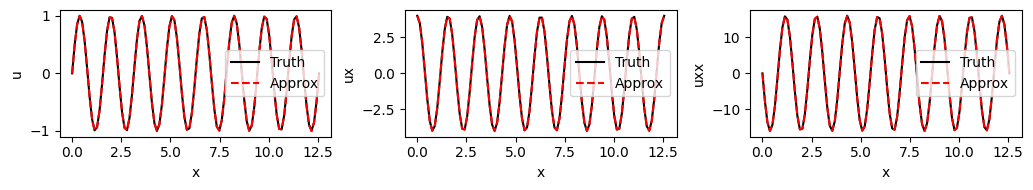

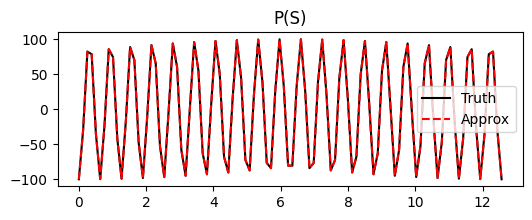

P(S) error: 6.847514455474242e-13


In [3]:
test_step1_error(noise_mag=0.0, _lambda=1e-5)
test_step2_error()

u error: 0.061693652058222116
ux error: 0.04694572296628998
uxx error: 0.05416166139545299


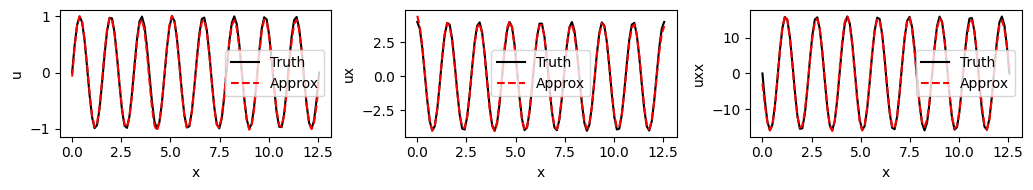

In [4]:
test_step1_error(noise_mag=0.1, _lambda=1e-2)